# Playing around with the ST_MNIST model by ST

## 1. Imports and function Definitions

In [9]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage
import yaml

def print_2d_array(arr):
    # make sure it’s a 2D array of ints (or cast to int for display)
    mat = np.array(arr, dtype=int)
    # figure out how wide the largest number is
    width = max(len(str(v)) for v in mat.flat)
    # print each row
    for row in mat:
        row_str = ', '.join(f'{v:{width}d}' for v in row)
        print(f'[{row_str}]')

## 2. Classnames and Model Loading

In [53]:
# — load class names
cfg = yaml.safe_load(open('models/MNIST/st_mnist_v1_28_tfs_config.yaml'))
class_names = cfg['dataset']['class_names']

# - load model
model = tf.keras.models.load_model('models/MNIST/st_mnist_v1_28_tfs.h5')
print("expects:", model.input_shape, model.input.dtype)

# - view all model layers
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} - output shape: {layer.output_shape}")

expects: (None, 28, 28, 1) <dtype: 'float32'>
0: input_1 - output shape: [(None, 28, 28, 1)]
1: conv2d - output shape: (None, 14, 14, 16)
2: batch_normalization - output shape: (None, 14, 14, 16)
3: re_lu - output shape: (None, 14, 14, 16)
4: depthwise_conv2d - output shape: (None, 14, 14, 16)
5: batch_normalization_1 - output shape: (None, 14, 14, 16)
6: re_lu_1 - output shape: (None, 14, 14, 16)
7: conv2d_1 - output shape: (None, 14, 14, 32)
8: batch_normalization_2 - output shape: (None, 14, 14, 32)
9: re_lu_2 - output shape: (None, 14, 14, 32)
10: depthwise_conv2d_1 - output shape: (None, 7, 7, 32)
11: batch_normalization_3 - output shape: (None, 7, 7, 32)
12: re_lu_3 - output shape: (None, 7, 7, 32)
13: conv2d_2 - output shape: (None, 7, 7, 64)
14: batch_normalization_4 - output shape: (None, 7, 7, 64)
15: re_lu_4 - output shape: (None, 7, 7, 64)
16: global_average_pooling2d - output shape: (None, 64)
17: dropout - output shape: (None, 64)
18: dense - output shape: (None, 36)


## 3. Loading and Preprocessing the image

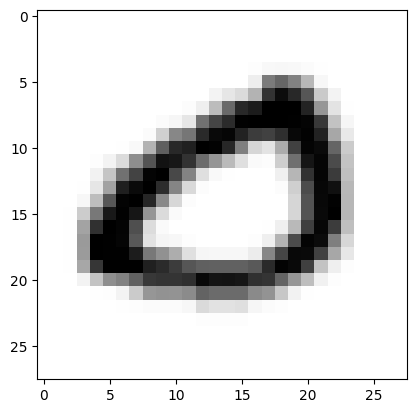

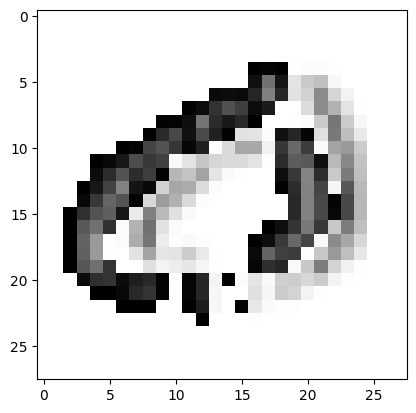

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  1,  0,  0,  0,  0, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  1, -1, -1,  0,  0,  0,  0,  0,

In [54]:
# — preprocess
img = Image.open('testImages/MNIST/azero.png') \
          .convert('L') \
          .resize((28,28), Image.NEAREST)
raw = np.array(img, np.uint8)
plt.imshow(raw, cmap='gray')
plt.show()
# - kind of replicating the GenX320 camera
raw = np.abs(np.diff(raw, axis=1))
raw = np.pad(raw, ((0,0),(1,0)), mode='constant')
raw = 255 - raw
plt.imshow(raw, cmap='gray')
plt.show()

# - it needs to be inverted for the model
raw_inv = 255 - raw

# - changing image to look like the training data
pre = raw_inv.astype(np.float32)/127.5 - 1.0
print_2d_array(pre)
print("raw→", raw.min(), raw.max(), "pre→", pre.min(), pre.max())
inp = pre.reshape((1,28,28,1))


## 4. Viewing Each Layer

### a. Getting Layer outputs for the input image

In [49]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(inp)

### b. Output the layer ouputs you would like

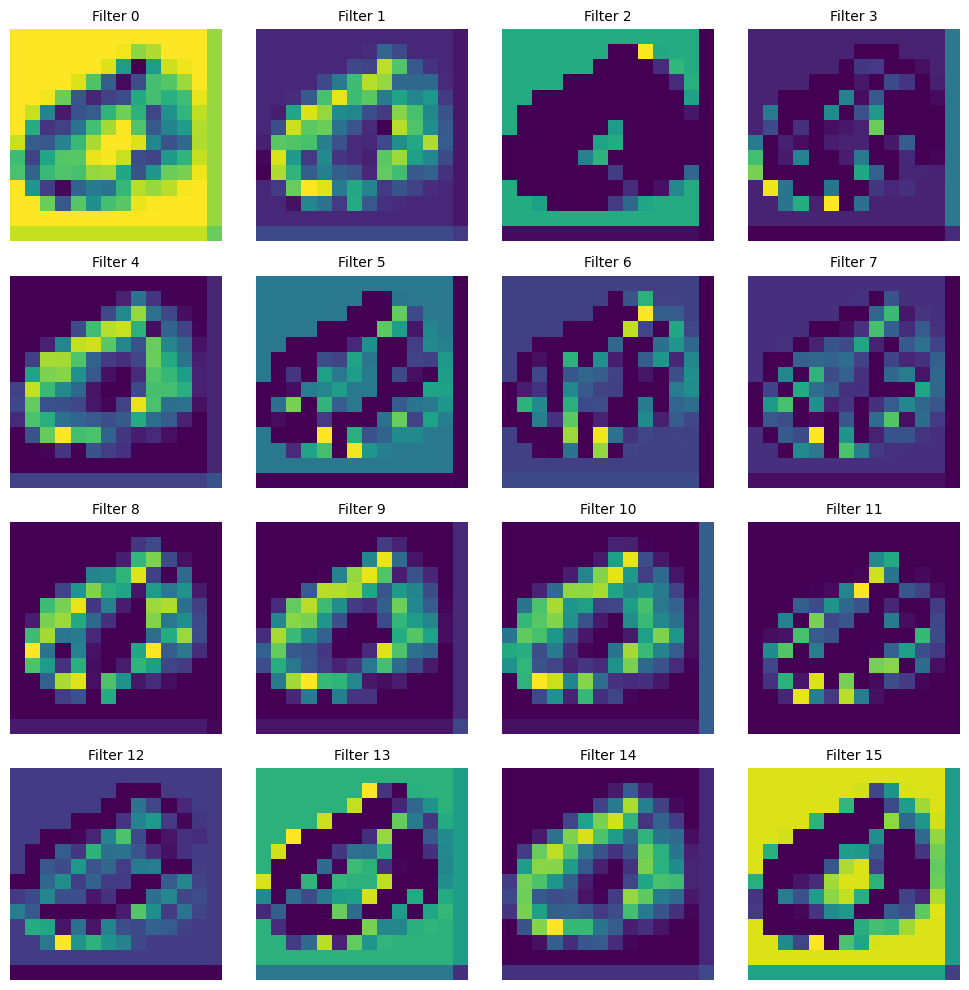

In [50]:
# relu_activations should be shape: (1, 14, 14, 16)
feature_maps = activations[3][0]  # Remove batch dimension

num_filters = feature_maps.shape[-1]
grid_size = int(num_filters ** 0.5)  # Assuming square grid (e.g., 4x4)

plt.figure(figsize=(10, 10))
for i in range(num_filters):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(feature_maps[:, :, i], cmap='viridis')
    plt.title(f'Filter {i}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 5. Using the model to predict

In [51]:
# — predict
probs = model.predict(inp)[0]
idx   = int(np.argmax(probs))
print(f"predicted: {idx} → {class_names[idx]}")
print("top-5:")
for i in np.argsort(probs)[-5:][::-1]:
    print(f"  {class_names[i]:>2}: {probs[i]:.4f}")

predicted: 0 → 0
top-5:
   0: 0.4213
   O: 0.2809
   C: 0.1168
   Q: 0.1051
   G: 0.0194


## 5. Testing with TFlite file used in ST

In [149]:
import numpy as np
import tensorflow as tf
from PIL import Image, ImageOps
import yaml

# 1) Load your class names
with open('st_mnist_v1_28_tfs_config.yaml','r') as f:
    cfg = yaml.safe_load(f)
class_names = cfg['dataset']['class_names']

# 2) Load & prepare the TFLite interpreter
interpreter = tf.lite.Interpreter('st_mnist_v1_28_tfs_int8.tflite')
interpreter.allocate_tensors()
inp_detail = interpreter.get_input_details()[0]
out_detail = interpreter.get_output_details()[0]

print("Model expects:", inp_detail['shape'], inp_detail['dtype'])
# e.g. [1,28,28,1], uint8

# 3) Load, invert, and reshape your image
img = Image.open('azero.png') \
          .convert('L') \
          .resize((28,28), Image.NEAREST)

# invert black/white
img_inv = ImageOps.invert(img)

raw = np.array(img_inv, dtype=np.uint8)      # shape (28,28)
data = raw.reshape((1,28,28,1))               # shape (1,28,28,1)

# sanity-check:
assert data.dtype == inp_detail['dtype']
assert data.shape == tuple(inp_detail['shape'])

# 4) Run inference
interpreter.set_tensor(inp_detail['index'], data)
interpreter.invoke()
probs = interpreter.get_tensor(out_detail['index'])[0]

# 5) Decode prediction
idx = int(np.argmax(probs))
print(f"Predicted: {idx} → {class_names[idx]}")
print("Top-5:")
for i in np.argsort(probs)[-5:][::-1]:
    print(f"  {class_names[i]:>2} : {probs[i]:.4f}")


Model expects: [ 1 28 28  1] <class 'numpy.uint8'>
Predicted: 24 → O
Top-5:
   O : 0.6484
   0 : 0.3398
   D : 0.0117
   G : 0.0000
   E : 0.0000
